In [2]:
import regex as re
import pandas as pd

from datasets import load_dataset
dataset = load_dataset("coastalcph/tydi_xor_rc")
df_train = dataset["train"].to_pandas()
df_val = dataset["validation"].to_pandas()

print(f"Train size:",df_train["lang"].value_counts())
print(f"Validation size:",df_val["lang"].value_counts())

Train size: lang
bn    2598
ar    2558
ko    2422
ja    2301
fi    2126
ru    1983
te    1355
Name: count, dtype: int64
Validation size: lang
fi    528
bn    476
ja    456
ar    415
ru    396
te    384
ko    356
Name: count, dtype: int64


In [3]:
print("First Columns", df_train.head(1))

First Columns                                             question  \
0  উইকিলিকস কত সালে সর্বপ্রথম ইন্টারনেটে প্রথম তথ...   

                                             context lang  answerable  \
0  WikiLeaks () is an international non-profit or...   bn        True   

   answer_start answer answer_inlang  
0           182   2006          None  


#### Checking Data Size

In [4]:
l = ["ar", "ko", "te", "en"]
df_train = df_train[df_train["lang"].isin(l)]
df_val = df_val[df_val["lang"].isin(l)]

In [5]:
print(f"Train Size: {df_train.shape}")
print(f"Validation Size: {df_val.shape}")

train_lan = df_train['lang'].value_counts()
val_len = df_val['lang'].value_counts()
print("Train Size per Language")
print(train_lan)
print("Validation Size per Language")
print(val_len) 

Train Size: (6335, 7)
Validation Size: (1155, 7)
Train Size per Language
lang
ar    2558
ko    2422
te    1355
Name: count, dtype: int64
Validation Size per Language
lang
ar    415
te    384
ko    356
Name: count, dtype: int64


### Word Count

In [23]:
df_total = pd.concat([df_val, df_train], axis=0)
df_total.reset_index(drop=True)

#Different Dataframes for Stats use
ar, ko, te = df_total[df_total["lang"] == "ar"], df_total[df_total["lang"] == "ko"], df_total[df_total["lang"] == "te"]
ar_val, ko_val, te_val = df_val[df_val["lang"] == "ar"], df_val[df_val["lang"] == "ko"], df_val[df_val["lang"] == "te"]
ar_tra, ko_tra, te_tra = df_train[df_train["lang"] == "ar"], df_train[df_train["lang"] == "ko"], df_train[df_train["lang"] == "te"]

def word_list(df):
    words = [re.findall(r'\w+', quest) for quest in df["question"]]
    return [w for q in words for w in q]

def PrintWordCountStats(langs_df, labels, title):     
    langs_words = [word_list(l) for l in langs_df]
    print(title)
    for i in range(len(langs_words)):
            print(f"Word counts for {labels[i]}: {len(langs_words[i])}")
    print("-"*30)

labels = ["Arabic", "Korean", "Telegu"]

PrintWordCountStats([ar,ko,te], labels, "Word Counts Total Dataset")
PrintWordCountStats([ar_tra,ko_tra,te_tra], labels, "Word Counts Training Dataset")
PrintWordCountStats([ar_val,ko_val,te_val], labels, "Word Counts Validation Dataset")


Word Counts Total Dataset
Word counts for Arabic: 18819
Word counts for Korean: 13600
Word counts for Telegu: 9992
------------------------------
Word Counts Training Dataset
Word counts for Arabic: 16202
Word counts for Korean: 11863
Word counts for Telegu: 7690
------------------------------
Word Counts Validation Dataset
Word counts for Arabic: 2617
Word counts for Korean: 1737
Word counts for Telegu: 2302
------------------------------


### Token Count

In [24]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")


def token_count(text):
    return len(tokenizer.tokenize(text))

def PrintTokenCountStats(langs_df, labels, title):
    print(title)
    for i in range(len(langs_df)):
        print(f"Word counts for {labels[i]}: {langs_df[i]['question'].apply(token_count).sum()}")
    print("-"*30)

PrintTokenCountStats([ar, ko, te], labels, "Word Counts Total Dataset")
PrintTokenCountStats([ar_tra, ko_tra, te_tra], labels, "Word Counts Training Dataset")
PrintTokenCountStats([ar_val, ko_val, te_val], labels, "Word Counts Validation Dataset")

Word Counts Total Dataset
Word counts for Arabic: 39337
Word counts for Korean: 29604
Word counts for Telegu: 23385
------------------------------
Word Counts Training Dataset
Word counts for Arabic: 33733
Word counts for Korean: 25829
Word counts for Telegu: 18365
------------------------------
Word Counts Validation Dataset
Word counts for Arabic: 5604
Word counts for Korean: 3775
Word counts for Telegu: 5020
------------------------------


### Most Common Words

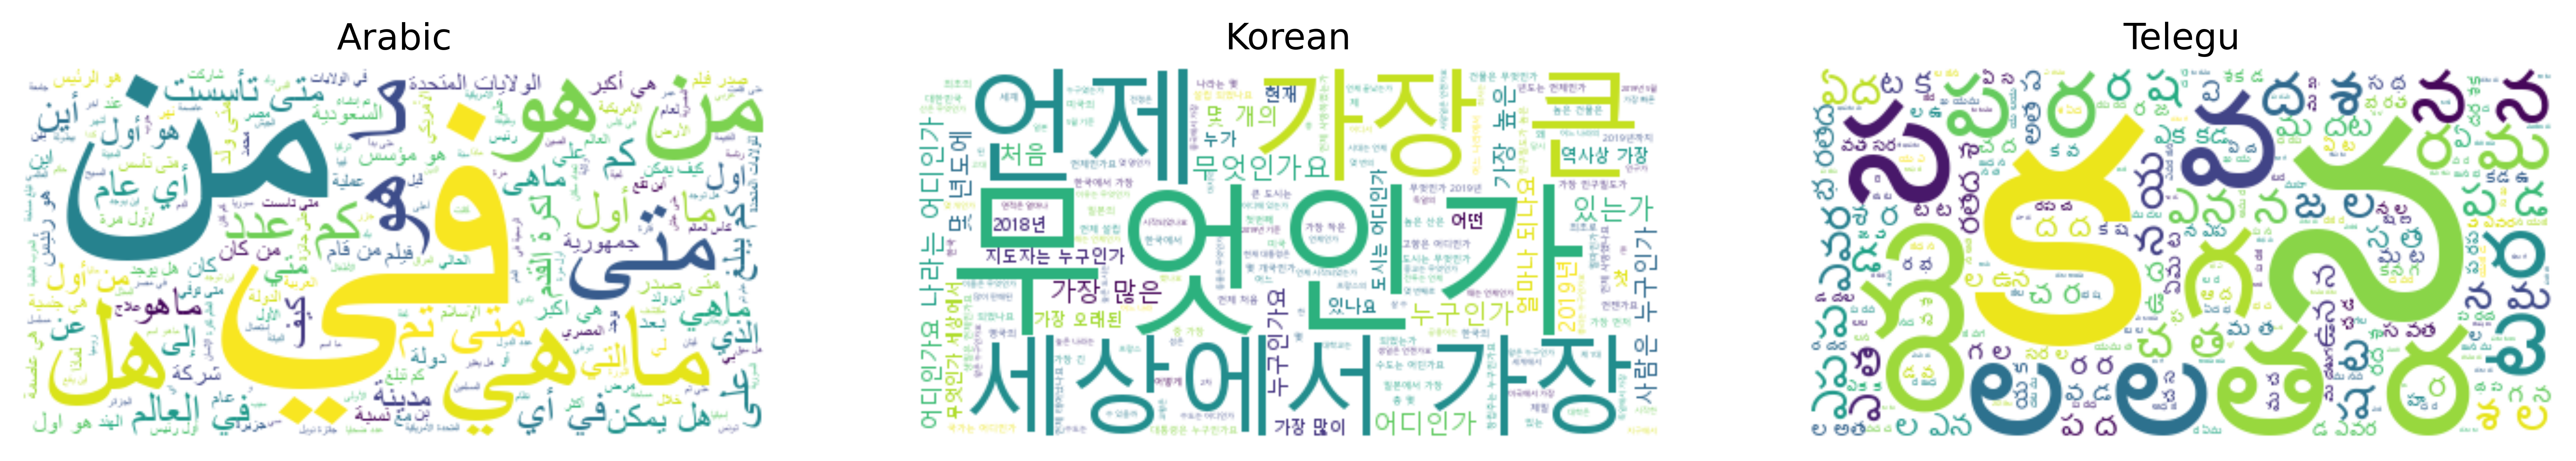

In [ ]:
# 5 Most common words 🙈
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

ar_words, ko_words, te_words = word_list(ar), word_list(ko), word_list(te)

def CreateWordCloud(wordlist, font, arabic=False):
    wordlist = " ".join(wordlist)
    if arabic:
        wordlist = arabic_reshaper.reshape(wordlist)
        wordlist = get_display(wordlist)
    return WordCloud(font_path=font, background_color='white').generate(wordlist)

def DisplayWordClouds(w_clouds, labels):
    plt.figure(figsize=(5*len(w_clouds), 5), dpi=600)

    for i in range(len(w_clouds)):
        plt.subplot(1, 3, i+1)
        plt.imshow(w_clouds[i], interpolation='bilinear')
        plt.title(labels[i])
        plt.axis('off')
    plt.show()


ar_wcloud = CreateWordCloud(ar_words, "arial.ttf", arabic=True)
ko_wcloud = CreateWordCloud(ko_words, "malgun.ttf")
te_wcloud = CreateWordCloud(te_words, "gautami.ttf")

DisplayWordClouds([ar_wcloud, ko_wcloud, te_wcloud], labels)

In [33]:
ar_freq = ar_wcloud.words_
top5 = sorted(ar_wcloud.words_.items(), key=lambda x: x[1], reverse=True)[:5]
print(top5)

[('ﻲﻓ', 1.0), ('ﻦﻣ', 0.72), ('ﻲﻫ ﺎﻣ', 0.6022222222222222), ('ﻞﻫ', 0.5866666666666667), ('ﻮﻫ ﻦﻣ', 0.58)]


### Translation

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

ko = ko.sample(5)
print(ko["question"].tolist())

tokenizer.src_lang = "kor_Hang"
inputs = tokenizer(ko["question"].tolist(), return_tensors="pt", padding=True)
forced_bos_token_id = tokenizer.convert_tokens_to_ids("eng_Latn")

outputs = model.generate(**inputs, forced_bos_token_id=forced_bos_token_id)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))


['드래곤 신화는 어느 나라에서 시작 되었는가?', '저영향 개발의 장점은 무엇인가?', '역사상 가장 많은 사상자를 불러온 전투는 무엇인가?', '미국 남북전쟁은 언제 끝났는가?', '오스만 제국의 1대 왕은 누구인가요?']
['In which country did the myth of the dragon originate?', "What's the advantage of low-level development?", 'What is the most deadly battle in history?', 'When did the American Civil War end?', 'Who was the first king of the Ottoman Empire?']


In [ ]:
# RULES
# 
# Who             (Proper Nouns)
# What            (???)
# When            (Dates)
# Where           (Proper Nouns)
# Why             (Because)
# How             (Bet on Yes)
# Whose           (Proper Nouns)
# Which           (Bet on Yes)
# How many/much   (Quantity)
#

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re
from tqdm import tqdm

splits = {'train': 'train.parquet', 'validation': 'validation.parquet'}
df_val = pd.read_parquet("hf://datasets/coastalcph/tydi_xor_rc/" + splits["validation"])

tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

lang_codes = {"ar": "ara_Arab", "ko": "kor_Hang", "te": "tel_Telu"}

def translate_to_en(texts, src_lang):
    tokenizer.src_lang = lang_codes[src_lang]
    outputs = []
    
    for i in tqdm(range(0, len(texts), 8), desc=f"Translating {src_lang}"):
        batch = texts[i:i+8]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        
        bos_token_id = tokenizer.convert_tokens_to_ids("eng_Latn")
        
        out = model.generate(**inputs, forced_bos_token_id=bos_token_id)
        outputs.extend(tokenizer.batch_decode(out, skip_special_tokens=True))
    
    return outputs

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    tokens = text.split()
    stopwords = {"the","is","a","an","in","on","at","and","of","to","for","with"}
    return set(t for t in tokens if t not in stopwords)

def predict_answerable(question, context):
    return 1 if len(preprocess(question) & preprocess(context)) > 0 else 0

results = {}

for lang in ["ar", "ko", "te"]:
    subset = df_val[df_val["lang"] == lang].copy()
    
    subset["question_en"] = translate_to_en(subset["question"].tolist(), lang)
    subset["context_en"] = translate_to_en(subset["context"].tolist(), lang)
    
    subset["pred"] = [predict_answerable(q, c) for q, c in tqdm(zip(subset["question_en"], subset["context_en"]), total=len(subset), desc=f"Predicting {lang}")]
    
    acc = accuracy_score(subset["answerable"], subset["pred"])
    prec, rec, f1, _ = precision_recall_fscore_support(subset["answerable"], subset["pred"], average="binary")
    
    results[lang] = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

print("Performance by language:")
for lang, metrics in results.items():
    print(lang, metrics)

Predicting te: 100%|██████████| 384/384 [00:00<00:00, 32483.82it/s]

Performance by language:
ar {'accuracy': 0.7975903614457831, 'precision': 0.8780487804878049, 'recall': 0.8925619834710744, 'f1': 0.8852459016393442}
ko {'accuracy': 0.8258426966292135, 'precision': 0.9508196721311475, 'recall': 0.8605341246290801, 'f1': 0.9034267912772586}
te {'accuracy': 0.7864583333333334, 'precision': 0.8028985507246377, 'recall': 0.9518900343642611, 'f1': 0.8710691823899371}
